# Fake news detection using LSTM model and Word2Vec

In [1]:
# Other
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import re
import gensim
from collections import Counter

#Sklearn
import sklearn
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Bidirectional

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikkonstenius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#fake = pd.read_csv(r"C:\Users\Erik Konstenius\Downloads\Fake.csv")
#true = pd.read_csv(r"C:\Users\Erik Konstenius\Downloads\True.csv")

fake = pd.read_csv(r"/Users/erikkonstenius/Downloads/Fake.csv")
true = pd.read_csv(r"/Users/erikkonstenius/Downloads/True.csv")

In [3]:
print("Example of fake news:")
print(fake["text"][4][0:300])
print("")
print(fake["text"][65][0:300])
print("")
print(fake["text"][200][0:300])
print("")
print(fake["text"][220][0:300])
print("")
print(fake["text"][300][0:300])

Example of fake news:
Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the  peace

Over the last few weeks, I ve watched as the last shreds of the Republican Party s  family values  rotted away.As Alabama voters prepare to go to the polls in December they have two choices before them.They can vote for the Democrat and prove that they refuse to tolerate an accused child molester an

 White House Chief of Staff John Kelly is a Four Star Marine General who gave his son to this nation. That is why it was such a relief when he joined the Trump White House. Everyone thought he d bring order to a dangerously chaotic situation. However, as Donald Trump s attacks on Rep. Frederica Wils

Donald Trump has recently come under fire for his most autocratic charge

In [4]:
print("Example of true news")
print(true["text"][4][0:300])
print("")
print(true["text"][65][0:300])
print("")
print(true["text"][200][0:300])
print("")
print(true["text"][220][0:300])
print("")
print(true["text"][300][0:300])

Example of true news
SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past.     “Why is the United States Post Office, which is losing ma

(Reuters) - Senator John Cornyn, the No. 2 Senate Republican, is trying to win support from the Midwest corn lobby for a broad legislative overhaul of the nation’s biofuels policy, according to sources familiar with the matter. The effort comes as President Donald Trump’s White House mediates talks 

WASHINGTON (Reuters) - The U.S. Congress will allow a deadline on reimposing sanctions on Iran to pass this week, congressional and White House aides said on Tuesday, leaving a pact between world powers and Tehran intact at least temporarily. In October, Trump declined to certify that Iran was compl

WASHINGTON (Reuters) - The White House on Monday said the Justice Departm

It appears as if the set of news articles that are considered true often start with the location and the newspaper that published the article. Let's investigate further how persistent this pattern is in the entire dataset.

In [5]:
three_words = []
for article in true["text"]:
    three_words.append(' '.join(article.split()[:3]))
    
dict_of_counts = {item:three_words.count(item) for item in three_words}
dict_of_counts = dict(Counter(dict_of_counts).most_common(10))
dict_of_counts # return the most frequent sequences of three words at the beginning of article

{'WASHINGTON (Reuters) -': 6443,
 'NEW YORK (Reuters)': 726,
 'LONDON (Reuters) -': 707,
 'MOSCOW (Reuters) -': 624,
 'BERLIN (Reuters) -': 503,
 'BEIJING (Reuters) -': 437,
 'BEIRUT (Reuters) -': 347,
 'BRUSSELS (Reuters) -': 346,
 'PARIS (Reuters) -': 301,
 'ANKARA (Reuters) -': 246}

The above script return the 10 most frequent first three words across all true articles. The result shows that a large portion of all articles contain this kind of structure.


I will remove the first three words if the word "Reuters" is present in the first three words. My motivation for this is that I want the model to predict whether it is fake or not based on the contents of the articles as opposed to how the two datasets are structured. I have also tried running the entire model when I included the locations and newspapers that publish the articles. It generated a near perfect accuracy. This indicated to me that there is something wrong with the used data.

In [6]:
text = []
for article in true["text"]:
    if "Reuters" in ' '.join(article.split()[:3]): # if "Reuters" exist in first three words
        text.append(' '.join(article.split(' ')[3:])) # remove first three words and append 
    else:
        text.append(article) # append the entire article if not contain "Reuters" in first three words

In [7]:
print("Number of true articles in truncated data: " + str(len(text)))
print("Number of true articles in original data: " + str(len(true["text"])))

Number of true articles in truncated data: 21417
Number of true articles in original data: 21417


In [8]:
print("Original data with locations and publisher")
print(true["text"][200][0:300])
print("")
print("Example of truncated articles")
print(text[200][0:300])

Original data with locations and publisher
WASHINGTON (Reuters) - The U.S. Congress will allow a deadline on reimposing sanctions on Iran to pass this week, congressional and White House aides said on Tuesday, leaving a pact between world powers and Tehran intact at least temporarily. In October, Trump declined to certify that Iran was compl

Example of truncated articles
The U.S. Congress will allow a deadline on reimposing sanctions on Iran to pass this week, congressional and White House aides said on Tuesday, leaving a pact between world powers and Tehran intact at least temporarily. In October, Trump declined to certify that Iran was complying with the nuclear a


In [9]:
# It seems to be convert it correctly. It is now ready to replace the original data
true["text"] = text

In [10]:
fake['Fake news?']=0
true['Fake news?']=1
df = true.append(fake).reset_index(drop=True)

In [11]:
df.head()

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",1


In [12]:
df.tail()

,title,text,subject,date,Fake news?
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [13]:
df.dtypes

title         object
text          object
subject       object
date          object
Fake news?     int64
dtype: object

In [14]:
df.isna().sum()

title         0
text          0
subject       0
date          0
Fake news?    0
dtype: int64

In [15]:
# convert text to lower case
df['text'] = df['text'].str.lower()

In [16]:
# remove stop words
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [17]:
# Let's look at some sentences
print(df['text'][0][0:250])

head conservative republican faction u.s. congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” sunday urged budget restraint 2018. keeping sharp pivot way among republicans, u.s. representative mark meadows, s


In [18]:
texts = []
for text in df['text']:
    temp = re.sub('[^A-Za-z0-9-" "]+', '', text) #remove special characters
    texts.append(re.sub(r'\b\w{1,2}\b', '', temp)) #remove short words

output = [word_tokenize(sentence) for sentence in texts]

df["text"] = output

In [19]:
# Let's look at some sentences
print(df['text'][0][0:100])

['head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', '2018', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'even', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'keep', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'big', 'budget', 'increase', 'military', 'spending', 'democrats', 'also', 'want', 'proportional', 'increases', 'non-defense', 'discretionary', 'spending', 'programs', 'support', 'education', 'scientific

In [20]:
word2vec = gensim.models.Word2Vec(sentences = df['text'], size = 100, window =5, min_count=1)

In [21]:
len(word2vec.wv.vocab) 

226461

In [22]:
word2vec.wv.most_similar("president")

[('president-elect', 0.7374012470245361),
 ('presidents', 0.699100911617279),
 ('presidency', 0.619046688079834),
 ('successor', 0.5715361833572388),
 ('pathetictrump', 0.5561524033546448),
 ('-soong', 0.544667661190033),
 ('versa', 0.5436614751815796),
 ('presidential', 0.5305578708648682),
 ('costwatchfeatured', 0.5217722654342651),
 ('baodong', 0.5087811946868896)]

In [23]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) #returns ID for the top 1000 words
tokenizer.fit_on_texts(df['text'])

In [24]:
df.head()

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...","[head, conservative, republican, faction, cong...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,"[transgender, people, allowed, first, time, en...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[special, counsel, investigation, links, russi...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,"[trump, campaign, adviser, george, papadopoulo...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,"[president, donald, trump, called, postal, ser...",politicsNews,"December 29, 2017",1


In [25]:
# Convert words to numbers
df['text'] = tokenizer.texts_to_sequences(df['text'])

In [26]:
df.head() # The text is now tokenized

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...","[311, 202, 16, 98, 647, 165, 42, 852, 335, 93,...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,"[5, 584, 30, 26, 81, 113, 78, 1, 110, 4, 10, 7...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[373, 163, 66, 4, 73, 119, 27, 22, 328, 151, 3...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,"[2, 22, 715, 589, 18, 39, 119, 66, 41, 57, 55,...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,"[4, 10, 2, 80, 440, 110, 97, 732, 101, 389, 97...",politicsNews,"December 29, 2017",1


In [27]:
# The text documents have different length
print(len(df["text"][0]))
print(len(df["text"][2]))

291
180


In [28]:
# To be able to run the model, the length of all vectors must be the same. I therefore documents to 
# the same length. This will be done in the following way.
# All texts are converted to the length of the 99 th percentile - I.e 845 words. 
# Texts longer than the length of the 99 th percentile get truncated. 
# Texts shorter than the length of the 99 th percentile get padded with 0s
# This method also removes outliers in terms of text length.

documents = []
for i in df["text"]:
    documents.append(i)

max_length = int(np.percentile([len(x) for x in documents],99))
word_index = tokenizer.word_index #enables conversion back to words

In [29]:
documents = sequence.pad_sequences(documents, maxlen=max_length,padding='post')
word_index = tokenizer.word_index #enables conversion back to words

In [30]:
weight_matrix = np.zeros((len(tokenizer.word_index)+1, 100))
for word, i in word_index.items():
    weight_matrix[i] = word2vec[word]

<ipython-input-30-63758b98cfe5>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  weight_matrix[i] = word2vec[word]


In [31]:
print("Number of words: " + str(len(weight_matrix))) 
print("Number of vectors for each word: " + str(len(weight_matrix[0])))

Number of words: 226462
Number of vectors for each word: 100


## Creating the LSTM model

We will begin by creating an embedding layer so that we can capture similarities between words using our glove method.

The construction of the model is partially determined by the achieved accuracy but also by the high risk of the vanishing and exploding gradient problem. More layers would capture more complex relations but it would also risk causing the exploding gradient problem

In [32]:
model = Sequential()
model.add(Embedding((len(word_index)+1), output_dim = 100, weights=[weight_matrix], trainable=False, input_length=max_length))
model.add(Bidirectional(LSTM(units=64,return_sequences=True, dropout = 0.35)))
model.add(Bidirectional(LSTM(units=32, dropout = 0.35)))
model.add(Dense(1, activation='sigmoid'))

# Training the model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(documents, df["Fake news?"], test_size=0.2, random_state=42)

In [34]:
# needs to be array for tensorflow's tensor conversion

X_train = np.asarray(X_train).astype('int64')
X_test = np.asarray(X_test).astype('int64')
y_train = np.asarray(y_train).astype('int64').reshape((-1,1))
y_test = np.asarray(y_test).astype('int64').reshape((-1,1))

In [35]:
# Check that the conversion works as expected
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

35918
8980
35918
8980


In [36]:
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate = 0.01), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 429, 100)          22646200  
                                                                 
 bidirectional (Bidirectiona  (None, 429, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 22,771,961
Trainable params: 125,761
Non-trainable params: 22,646,200
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=2, validation_split = 0.2, batch_size=64)
model.save("LSTM_model")

Epoch 1/2
449/449 [==============================] - 527s 1s/step - loss: 0.1544 - accuracy: 0.9416 - val_loss: 0.0664 - val_accuracy: 0.9784
Epoch 2/2
449/449 [==============================] - 517s 1s/step - loss: 0.0737 - accuracy: 0.9743 - val_loss: 0.0433 - val_accuracy: 0.9851


INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


# Evaluating the model

#### Accuracy, precision, recall, f1-score

In [38]:
model = keras.models.load_model('LSTM_model')

y_pred = (model.predict(X_test) > 0.5).astype("int64")

In [39]:
accuracy_score(y_test, y_pred)

0.9809576837416482

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4650
           1       0.98      0.98      0.98      4330

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



#### Precision-Recall Curve

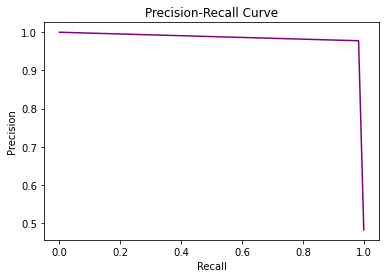

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

#### ROC Plot

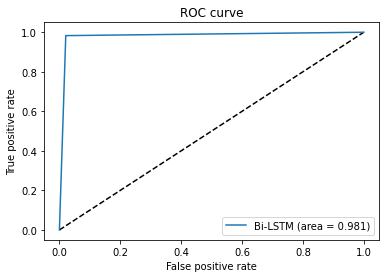

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Bi-LSTM (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Conclusion

The model provided very good results on both the training data and the testing data. 